In [ ]:
!pip install prometheus-api prometheus_api_client google-cloud-bigquery google-cloud-bigquery-storage db-dtypes

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for prometheus-api: filename=prometheus_api-0.0.1-py3-none-any.whl size=2469 sha256=d2290aef6d3a802ed12ee61c4f9fa9ec4b95d2c7a97f9ebae7f7d0dca7e68525
  Stored in directory: /root/.cache/pip/wheels/6e/a0/29/69eb6dd086b9e62de9b06e5812175b4dc4e7c028a86d9ab09b
Successfully built prometheus-api


In [ ]:
import pandas as pd
import numpy as np
import altair as alt
from google.cloud import bigquery
from google.cloud import bigquery_storage
import matplotlib.pyplot as plt, os, random
from scipy import stats
import prometheus_api_client
import tensorflow as tf


# Provide credentials to the runtime
from google.colab import auth
from google.cloud.bigquery import magics

auth.authenticate_user()
print('Authenticated')
project_id = 'poc-marvel'
# Set the default project id for %bigquery magic
magics.context.project = project_id

# Use the client to run queries constructed from a more complicated function.
client = bigquery.Client(project=project_id)
bqstorage_client = bigquery_storage.BigQueryReadClient()
CELL = 'c'

Authenticated


✓ gct_clean.pkl salvo


<ipython-input-3-ba6eb0fdcf19>:79: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  gaps   = prom_raw.index.to_series().diff().gt("2H")


Prometheus – bloco #0: 2021-02-02 05:00:04.720999936+00:00 → 2021-02-09 04:59:54.709000192+00:00 (60480 samples)
✓ prom_clean_7d.pkl salvo   (336 pontos)
✓ scale_params.json atualizado


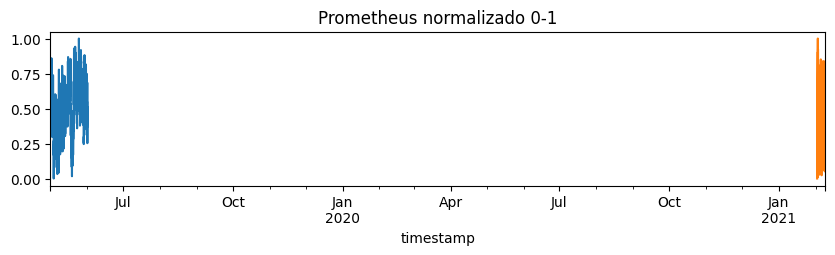

In [ ]:
# ============================================================================
# 01 · Limpeza & Escalonamento (Prometheus + Google Cluster Trace 2019‑C)
# Todos os arquivos serão salvos em DATA_DIR
# ============================================================================

import os, json, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import stats
from google.colab import auth
from google.cloud import bigquery, bigquery_storage

# ---------- configuração ----------------------------------------------------
DATA_DIR = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
os.makedirs(DATA_DIR, exist_ok=True)
PROJECT_ID = "poc-marvel"
CELL       = "c"            # Borg cell
auth.authenticate_user()

# ---------- função de limpeza + escala -------------------------------------
def clean_series(series, freq="30min"):
    """Retorna série normalizada 0‑1 e dicionário {log_min, log_max}"""
    s = series.resample(freq).mean()
    s = s.interpolate("spline", order=3)
    z = np.abs(stats.zscore(s, nan_policy="omit"))
    s[z > 3] = np.nan
    s = s.interpolate("spline", order=3)

    log_s  = np.log1p(s)
    log_min, log_max = log_s.min(), log_s.max()
    s_norm = (log_s - log_min) / (log_max - log_min)
    return s_norm, {"log_min": float(log_min), "log_max": float(log_max)}

# ---------- 1. Google Cluster Trace ----------------------------------------
client = bigquery.Client(project=PROJECT_ID)
bqstor = bigquery_storage.BigQueryReadClient()

# 1.1 capacidade total da célula
qry_cap = f"""
SELECT SUM(memory_cap) AS mem_cap
FROM (
  SELECT machine_id, MAX(capacity.memory) AS memory_cap
  FROM `google.com:google-cluster-data`.clusterdata_2019_{CELL}.machine_events
  GROUP BY machine_id )
"""
cell_cap = client.query(qry_cap).result().to_dataframe()["mem_cap"][0]

# 1.2 série de 30 min
qry_ts = f"""
WITH per_instance AS (
  SELECT start_time AS t, average_usage.memory AS m
  FROM `google.com:google-cluster-data`.clusterdata_2019_{CELL}.instance_usage
  WHERE (alloc_collection_id IS NULL OR alloc_collection_id = 0)
    AND (end_time - start_time) >= (5 * 60 * 1e6)
),
per_30 AS (
  SELECT CAST(FLOOR(t/(1e6*60*30)) AS INT64) AS slot,
         SUM(m)/(6*{cell_cap})                 AS mem_norm
  FROM per_instance GROUP BY slot )
SELECT slot, mem_norm FROM per_30 ORDER BY slot
"""
df = client.query(qry_ts).result().to_dataframe(bqstorage_client=bqstor)
origin = pd.Timestamp("2019-05-01", tz="UTC")
df["timestamp"] = origin + pd.to_timedelta(df.slot*30, unit="min")
gct_raw = df.set_index("timestamp")["mem_norm"].asfreq("30min")

gct_clean, gct_scale = clean_series(gct_raw)
gct_clean.to_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))
print("✓ gct_clean.pkl salvo")

# ---------- 2. Prometheus (recorte 7 dias) ---------------------------------
prom_raw = pd.read_pickle(os.path.join(DATA_DIR, "ts.pkl"))

# garante DateTimeIndex + numérico
if not isinstance(prom_raw.index, pd.DatetimeIndex):
    prom_raw.index = pd.to_datetime(prom_raw.index, unit="s")
prom_raw["value"] = pd.to_numeric(prom_raw["value"], errors="coerce")
prom_raw = prom_raw.sort_index()

# 2.1 detectar blocos contíguos (gap > 2h abre novo bloco)
gaps   = prom_raw.index.to_series().diff().gt("2H")
blocks = gaps.cumsum()
first_block = blocks.eq(0)             # bloco #0
prom_block  = prom_raw.loc[first_block, "value"]

print("Prometheus – bloco #0:",
      prom_block.index.min(), "→", prom_block.index.max(),
      f"({len(prom_block)} samples)")

# 2.2 limpeza + escala só nesse bloco
prom_clean, prom_scale = clean_series(prom_block)
prom_path = os.path.join(DATA_DIR, "prom_clean_7d.pkl")
prom_clean.to_pickle(prom_path)
print(f"✓ prom_clean_7d.pkl salvo   ({len(prom_clean)} pontos)")

# ---------- 3. atualizar scale_params.json ---------------------------------
scale_file = os.path.join(DATA_DIR, "scale_params.json")
with open(scale_file) as fp:
    scale_dict = json.load(fp)

scale_dict["Prometheus"] = prom_scale     # substitui entrada anterior

with open(scale_file, "w") as fp:
    json.dump(scale_dict, fp, indent=2)
print("✓ scale_params.json atualizado")


# ---------- 4. visualização opcional ---------------------------------------
for name, s in [("GCT", gct_clean), ("Prometheus", prom_clean)]:
    s.plot(figsize=(10,2), title=f"{name} normalizado 0‑1")
plt.show()


In [ ]:
from threading import local
# ============================================================================
# 02 · Baseline LSTM  — Google Cluster Trace 2019‑C
# Métricas em fração da capacidade (0‑1)  +  tempo médio por seed
# ============================================================================

import os, json, time, numpy as np, pandas as pd, tensorflow as tf, pickle
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# ---------- GPU -----------------------------------------------------------------
import tensorflow as tf
import os


gpus = tf.config.list_physical_devices('GPU')
if gpus:
  print(f"✅ GPU detectada: {[gpu.name for gpu in gpus]}")
  tf.keras.mixed_precision.set_global_policy("mixed_float16")
  strategy = tf.distribute.MirroredStrategy()
  print(f"Estratégia de distribuição: {strategy}")

#import tensorflow as tf
#
#try:
#    # Inicialização da TPU
#    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
#    tf.config.experimental_connect_to_cluster(resolver)
#    tf.tpu.experimental.initialize_tpu_system(resolver)
#   strategy = tf.distribute.TPUStrategy(resolver)
#    print("✅ TPU inicializada com sucesso!")
#except ValueError:
#    print("⚠️ TPU não detectada. Verifique se o runtime está configurado para TPU.")



# ---------- paths & seeds --------------------------------------------------------
DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics"); os.makedirs(METRIC_DIR, exist_ok=True)
SEEDS = range(42, 62)          # 20 execuções

# ---------- carregar Google Trace -----------------------------------------------
gct = pd.read_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))

# ---------- utilidades ----------------------------------------------------------
def make_xy(series, n_steps):
    arr = series.to_numpy()
    X, y = [], []
    for i in range(n_steps, len(arr)):
        X.append(arr[i-n_steps:i])
        y.append(arr[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def split_series(s, train=0.7, val=0.1):
    n = len(s); i_tr, i_val = int(n*train), int(n*(train+val))
    return s[:i_tr], s[i_tr:i_val], s[i_val:]

def build_lstm(n_steps, units=100, dr=0.3, l2=1e-4):
    reg = tf.keras.regularizers.l2(l2)
    return Sequential([
        Input(shape=(n_steps,1)),
        LSTM(units, return_sequences=True, kernel_regularizer=reg),
        Dropout(dr),
        LSTM(units, kernel_regularizer=reg),
        Dropout(dr),
        Dense(1, dtype="float32")
    ])

def evaluate_norm(model, test, n_steps):
    Xte, y = make_xy(test, n_steps)
    pred = model.predict(Xte, verbose=0).squeeze()
    rmse  = np.sqrt(mean_squared_error(y, pred))
    mae   = mean_absolute_error(y, pred)
    mape  = mean_absolute_percentage_error(y, pred)
    smape = 200*np.mean(np.abs(pred - y)/(np.abs(pred)+np.abs(y)))
    return rmse, mae, mape, smape

def ci(arr):
    boot = np.random.choice(arr, (1000, len(arr)), replace=True).mean(axis=1)
    return np.percentile(boot, [2.5, 97.5])

# ---------- experimento ---------------------------------------------------------
train, val, test = split_series(gct)
n_steps = 48
metrics_time = []   # (rmse, mae, mape, smape, seconds)

for seed in SEEDS:
    tf.keras.utils.set_random_seed(seed)
    Xtr, ytr = make_xy(train, n_steps)
    Xva, yva = make_xy(pd.concat([train[-n_steps:], val]), n_steps)

    model = build_lstm(n_steps)
    model.compile("adam", "mse")

    t0 = time.time()
    model.fit(Xtr, ytr, epochs=100, batch_size=64,
              validation_data=(Xva, yva),
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
              verbose=0)
    elapsed = time.time() - t0

    rmse, mae, mape, smape = evaluate_norm(model, test, n_steps)
    metrics_time.append((rmse, mae, mape, smape, elapsed))

# ---------- resumo --------------------------------------------------------------
r = np.array(metrics_time)
rmse, mae, mape, smape, tsec = r.T

print("\nGoogle Trace – LSTM baseline  (fração 0‑1)")
print(f"RMSE  mean={rmse.mean():.4f}  IC95%={ci(rmse)}")
print(f"MAE   mean={mae.mean():.4f}  IC95%={ci(mae)}")
print(f"MAPE  mean={mape.mean():.4f}  IC95%={ci(mape)}")
print(f"SMAPE mean={smape.mean():.2f}  IC95%={ci(smape)}")
print(f"Tempo médio de treino por seed: {tsec.mean():.1f} s ±{tsec.std():.1f}")

# ---------- salvar métricas -----------------------------------------------------
out = dict(RMSE=rmse, MAE=mae, MAPE=mape, SMAPE=smape, TIME=tsec)
with open(os.path.join(METRIC_DIR, "baseline_gct_norm.pkl"), "wb") as fp:
    pickle.dump(out, fp)
print("\n✓ baseline_gct_norm.pkl salvo")


✅ GPU detectada: ['/physical_device:GPU:0']
Estratégia de distribuição: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7b987c466910>



Google Trace – LSTM baseline  (fração 0‑1)
RMSE  mean=0.0743  IC95%=[0.07376132 0.07507304]
MAE   mean=0.0585  IC95%=[0.05799273 0.05911246]
MAPE  mean=0.1120  IC95%=[0.11113023 0.11304321]
SMAPE mean=10.89  IC95%=[10.79865439 11.01318645]
Tempo médio de treino por seed: 23.5 s ±1.7

✓ baseline_gct_norm.pkl salvo


GPU: /physical_device:GPU:0
Iter 01/30  best_RMSE=0.0916  cfg=[96, 224, 0.1, 5.771551596033568e-05]
Iter 02/30  best_RMSE=0.0914  cfg=[96, 224, 0.1, 6.383337896761335e-05]
Iter 03/30  best_RMSE=0.0911  cfg=[96, 256, 0.1, 3.632892094896544e-05]
Iter 04/30  best_RMSE=0.0905  cfg=[96, 256, 0.1, 1.2784987844323605e-05]
Iter 05/30  best_RMSE=0.0899  cfg=[96, 256, 0.1, 1.278186463598944e-05]
Iter 06/30  best_RMSE=0.0898  cfg=[96, 256, 0.1, 1.8168201926796115e-05]
Iter 07/30  best_RMSE=0.0898  cfg=[96, 256, 0.1, 1.8168201926796115e-05]
Iter 08/30  best_RMSE=0.0898  cfg=[96, 256, 0.1, 1.8168201926796115e-05]
Iter 09/30  best_RMSE=0.0896  cfg=[96, 256, 0.1, 1.9400501111022033e-05]
Iter 10/30  best_RMSE=0.0896  cfg=[96, 256, 0.1, 1.9400501111022033e-05]
Iter 11/30  best_RMSE=0.0896  cfg=[96, 256, 0.1, 1.9400501111022033e-05]
Iter 12/30  best_RMSE=0.0896  cfg=[96, 256, 0.1, 1.9400501111022033e-05]
Iter 13/30  best_RMSE=0.0896  cfg=[96, 256, 0.1, 1.9400501111022033e-05]
Iter 14/30  best_RMSE=0.089

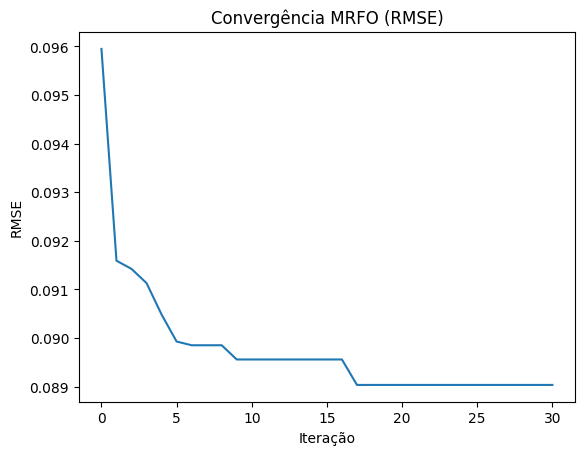

✓ artefatos salvos em ../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/metrics


In [ ]:
# ============================================================================
# 03 · MRFO + LSTM — Google Trace  (fração 0‑1)   ·   GPU A100 otimizada
# POP = 15   ·   ITER = 30
# ============================================================================

# ---- imports, dados, utilidades --------------------------------------------
import os, json, time, math, pickle, pathlib, random
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics"); pathlib.Path(METRIC_DIR).mkdir(exist_ok=True)
gct = pd.read_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))

# -------- GPU policy ---------------------------------------------------------
physical = tf.config.list_physical_devices('GPU')
assert physical, "GPU não detectada — ative‑a no Colab!"
tf.keras.mixed_precision.set_global_policy("mixed_float16")
print("GPU:", physical[0].name)

# -------- funções auxiliares -------------------------------------------------
def make_xy(series, n_steps):
    arr = series.to_numpy()
    X, y = [], []
    for i in range(n_steps, len(arr)):
        X.append(arr[i-n_steps:i])
        y.append(arr[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def split_series(s, train=0.7):
    i_tr = int(len(s)*train)
    return s[:i_tr], s[i_tr:]

def build_lstm(n_steps, units, dr, l2):
    reg = tf.keras.regularizers.l2(l2)
    return Sequential([
        Input(shape=(n_steps,1)),
        LSTM(units, return_sequences=True, kernel_regularizer=reg),
        Dropout(dr),
        LSTM(units, kernel_regularizer=reg),
        Dropout(dr),
        Dense(1, dtype="float32")
    ])

# -------- função‑objetivo (rápida) ------------------------------------------
def evaluate_cv(params):
    n_steps, units, dr, l2 = params
    train, test = split_series(gct, 0.7)          # 70 % treino, 30 % teste
    Xtr, ytr = make_xy(train, n_steps)

    model = build_lstm(n_steps, units, dr, l2)
    model.compile("adam", "mse")
    model.fit(Xtr, ytr,
              epochs=30,
              batch_size=256,
              validation_split=0.1,
              callbacks=[EarlyStopping(patience=4, restore_best_weights=True)],
              verbose=0)

    # avalia em 3 segmentos do teste
    rmses = []
    for idx in np.array_split(test.index, 3):
        seg = test.loc[idx]                       # <-- nome diferente
        Xv, yv = make_xy(pd.concat([train[-n_steps:], seg]), n_steps)
        pred = model.predict(Xv, verbose=0).squeeze()
        rmses.append(math.sqrt(mean_squared_error(yv, pred)))
    return float(np.mean(rmses))



# -------- espaço de busca & MRFO params -------------------------------------
space = {"n_steps": (24, 96), "units": (32, 256), "dr": (0.1, 0.5), "l2": (1e-6, 1e-3)}
def sample_agent():
    ns = int(np.random.choice(range(24,97,12)))
    un = int(np.random.choice(range(32,257,32)))
    dr = np.random.uniform(*space["dr"])
    l2 = 10**np.random.uniform(np.log10(space["l2"][0]), np.log10(space["l2"][1]))
    return [ns, un, dr, l2]

POP, N_ITER = 15, 30
alpha, beta, gamma0 = 1.5, 1.0, 2.0
p_chain, p_cyc, p_som = 0.4, 0.4, 0.2
np.random.seed(42)

def fitness_batch(pop):   # sequencial (uma GPU)
    return [evaluate_cv(p) for p in pop]

# -------- inicialização ------------------------------------------------------
pop = [sample_agent() for _ in range(POP)]
fit = fitness_batch(pop)
best_idx = int(np.argmin(fit))
best, best_fit = pop[best_idx], fit[best_idx]
convergence = [best_fit]

# -------- loop MRFO ----------------------------------------------------------
t0_all = time.time()
for t in range(1, N_ITER+1):
    p = np.random.rand()
    for i in range(POP):
        if p < p_chain:                # chain
            r = np.random.rand()
            pop[i] = (np.array(best) + alpha*r*(np.array(best)-np.array(pop[i]))).tolist()
        elif p < p_chain+p_cyc:        # cyclone
            r = np.random.rand()
            beta_t = beta*math.exp(-t/N_ITER)
            pop[i] = (np.array(best) + beta_t*r*(np.array(best)-np.array(pop[i]))).tolist()
        else:                          # somersault
            r = np.random.uniform(-1,1,len(best))
            gamma_t = gamma0*math.exp(-t/N_ITER)
            pop[i] = (np.array(pop[i]) + gamma_t*r*(np.array(best)-np.array(pop[i]))).tolist()

        # limites
        pop[i][0] = int(np.clip(round(pop[i][0]/12)*12, 24, 96))
        pop[i][1] = int(np.clip(round(pop[i][1]/32)*32, 32, 256))
        pop[i][2] = float(np.clip(pop[i][2], *space["dr"]))
        pop[i][3] = float(np.clip(pop[i][3], *space["l2"]))

    fit = fitness_batch(pop)
    if min(fit) < best_fit:
        best_fit = min(fit); best = pop[int(np.argmin(fit))]
    convergence.append(best_fit)
    print(f"Iter {t:02d}/{N_ITER}  best_RMSE={best_fit:.4f}  cfg={best}")

total_time = time.time() - t0_all

# -------- salvar artefatos ---------------------------------------------------
with open(os.path.join(METRIC_DIR, "mrfo_best_params.json"), "w") as fp:
    json.dump({"params": best, "rmse": best_fit, "time_sec": total_time}, fp, indent=2)
np.save(os.path.join(METRIC_DIR, "mrfo_convergence.npy"), np.array(convergence))

print(f"\nTempo total MRFO: {total_time/60:.1f} min")

import matplotlib.pyplot as plt
plt.plot(convergence)
plt.title("Convergência MRFO (RMSE)")
plt.xlabel("Iteração"); plt.ylabel("RMSE")
plt.savefig(os.path.join(METRIC_DIR, "mrfo_convergence.png")); plt.show()
print("✓ artefatos salvos em", METRIC_DIR)

GPU: /physical_device:GPU:0
Iter 01/20  best_RMSE=0.0913  cfg=[96, 256, 0.1665816380814888, 1e-06]
Iter 02/20  best_RMSE=0.0903  cfg=[96, 256, 0.1652463418640881, 1e-06]
Iter 03/20  best_RMSE=0.0903  cfg=[96, 256, 0.1652463418640881, 1e-06]
Iter 04/20  best_RMSE=0.0903  cfg=[96, 256, 0.1652463418640881, 1e-06]
Iter 05/20  best_RMSE=0.0903  cfg=[96, 256, 0.1652463418640881, 1e-06]
Iter 06/20  best_RMSE=0.0903  cfg=[96, 256, 0.1652463418640881, 1e-06]
Iter 07/20  best_RMSE=0.0903  cfg=[96, 256, 0.1652463418640881, 1e-06]
Iter 08/20  best_RMSE=0.0903  cfg=[96, 256, 0.1652463418640881, 1e-06]
Iter 09/20  best_RMSE=0.0903  cfg=[96, 256, 0.1652463418640881, 1e-06]
Iter 10/20  best_RMSE=0.0903  cfg=[96, 256, 0.1652463418640881, 1e-06]
Iter 11/20  best_RMSE=0.0903  cfg=[96, 256, 0.1652463418640881, 1e-06]
Iter 12/20  best_RMSE=0.0903  cfg=[96, 256, 0.1652463418640881, 1e-06]
Iter 13/20  best_RMSE=0.0903  cfg=[96, 256, 0.1652463418640881, 1e-06]
Iter 14/20  best_RMSE=0.0903  cfg=[96, 256, 0.165

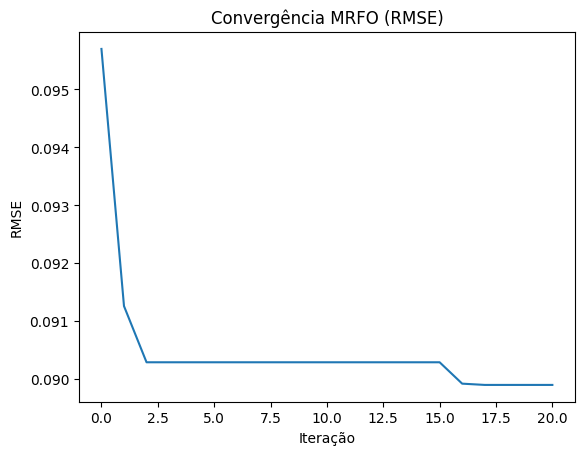

✓ artefatos salvos em ../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/metrics


In [ ]:
# ============================================================================
# 03 · MRFO + LSTM — Google Trace  (fração 0‑1)            GPU A100
# POP = 15   ·   ITER = 20   ·   2‑fold sliding CV
# ============================================================================

import os, json, time, math, pickle, pathlib, random
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---------- paths ------------------------------------------------------------
DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics"); pathlib.Path(METRIC_DIR).mkdir(exist_ok=True)
gct = pd.read_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))

# ---------- GPU policy -------------------------------------------------------
physical = tf.config.list_physical_devices('GPU')
assert physical, "GPU não detectada"
tf.keras.mixed_precision.set_global_policy("mixed_float16")
print("GPU:", physical[0].name)

# ---------- helpers ----------------------------------------------------------
def make_xy(series, n_steps):
    a = series.to_numpy()
    X, y = [], []
    for i in range(n_steps, len(a)):
        X.append(a[i-n_steps:i])
        y.append(a[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def sliding_splits(series, k=2):
    n = len(series)//k
    for i in range(k):
        val = series[i*n:(i+1)*n]
        train = series.drop(val.index)
        yield train, val

def build_lstm(n_steps, units, dr, l2):
    reg = tf.keras.regularizers.l2(l2)
    return Sequential([
        Input(shape=(n_steps,1)),
        LSTM(units, return_sequences=True, kernel_regularizer=reg),
        Dropout(dr),
        LSTM(units, kernel_regularizer=reg),
        Dropout(dr),
        Dense(1, dtype="float32")
    ])

# ---------- função‑objetivo --------------------------------------------------
def evaluate_cv(params):
    n_steps, units, dr, l2 = params
    rmses = []
    for train, val in sliding_splits(gct, k=2):          # ← 2‑fold CV
        Xtr, ytr = make_xy(train, n_steps)
        Xva, yva = make_xy(pd.concat([train[-n_steps:], val]), n_steps)

        ds_tr = (tf.data.Dataset.from_tensor_slices((Xtr, ytr))
                 .batch(256).prefetch(tf.data.AUTOTUNE))
        ds_va = tf.data.Dataset.from_tensor_slices((Xva, yva)).batch(256)

        model = build_lstm(n_steps, units, dr, l2)
        model.compile("adam", "mse")
        model.fit(ds_tr,
                  epochs=40,
                  validation_data=ds_va,
                  callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                  verbose=0)

        pred = model.predict(ds_va, verbose=0).squeeze()
        rmses.append(math.sqrt(mean_squared_error(yva, pred)))
    return float(np.mean(rmses))

# ---------- busca MRFO -------------------------------------------------------
space = {"n_steps": (24, 96), "units": (32, 256), "dr": (0.1, 0.5), "l2": (1e-6, 1e-3)}
def sample_agent():
    ns = int(np.random.choice(range(24,97,12)))
    un = int(np.random.choice(range(32,257,32)))
    dr = np.random.uniform(*space["dr"])
    l2 = 10**np.random.uniform(np.log10(space["l2"][0]), np.log10(space["l2"][1]))
    return [ns, un, dr, l2]

POP, N_ITER = 15, 20
alpha, beta, gamma0 = 1.5, 1.0, 2.0
p_chain, p_cyc, p_som = 0.4, 0.4, 0.2
np.random.seed(42)

def fitness_batch(pop):   # sequencial
    return [evaluate_cv(p) for p in pop]

# ---------- inicialização ----------------------------------------------------
pop = [sample_agent() for _ in range(POP)]
fit = fitness_batch(pop)
best_idx = int(np.argmin(fit)); best, best_fit = pop[best_idx], fit[best_idx]
convergence = [best_fit]

# ---------- loop MRFO --------------------------------------------------------
t0_all = time.time()
for t in range(1, N_ITER+1):
    p = np.random.rand()
    for i in range(POP):
        if p < p_chain:              # chain
            r = np.random.rand()
            pop[i] = (np.array(best) + 1.5*r*(np.array(best)-np.array(pop[i]))).tolist()
        elif p < p_chain+p_cyc:      # cyclone
            r = np.random.rand()
            beta_t = beta*math.exp(-t/N_ITER)
            pop[i] = (np.array(best) + beta_t*r*(np.array(best)-np.array(pop[i]))).tolist()
        else:                        # somersault
            r = np.random.uniform(-1,1,len(best))
            gamma_t = gamma0*math.exp(-t/N_ITER)
            pop[i] = (np.array(pop[i]) + gamma_t*r*(np.array(best)-np.array(pop[i]))).tolist()

        # clamp + cast
        pop[i][0] = int(np.clip(round(pop[i][0]/12)*12, 24, 96))
        pop[i][1] = int(np.clip(round(pop[i][1]/32)*32, 32, 256))
        pop[i][2] = float(np.clip(pop[i][2], *space["dr"]))
        pop[i][3] = float(np.clip(pop[i][3], *space["l2"]))

    fit = fitness_batch(pop)
    if min(fit) < best_fit:
        best_fit = min(fit); best = pop[int(np.argmin(fit))]
    convergence.append(best_fit)
    print(f"Iter {t:02d}/{N_ITER}  best_RMSE={best_fit:.4f}  cfg={best}")

total_time = time.time() - t0_all

# ---------- salvar artefatos -------------------------------------------------
with open(os.path.join(METRIC_DIR, "mrfo_best_params.json"), "w") as fp:
    json.dump({"params": best, "rmse": best_fit, "time_sec": total_time}, fp, indent=2)
np.save(os.path.join(METRIC_DIR, "mrfo_convergence.npy"), np.array(convergence))

print(f"\nTempo total MRFO: {total_time/60:.1f} min")

import matplotlib.pyplot as plt
plt.plot(convergence)
plt.title("Convergência MRFO (RMSE)")
plt.xlabel("Iteração"); plt.ylabel("RMSE")
plt.savefig(os.path.join(METRIC_DIR, "mrfo_convergence.png")); plt.show()
print("✓ artefatos salvos em", METRIC_DIR)


In [ ]:
# ============================================================================
# 03 · MRFO + LSTM — Google Trace  (fração 0‑1)         GPU A100
# POP = 30 · ITER = 50 · epochs = 100 · patience = 10
# Salva RMSE / MAE / MAPE / SMAPE  +  tempo por iteração
# ============================================================================

# ------------------- imports e dados ----------------------------------------
import os, json, time, math, pickle, pathlib, random
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

DATA_DIR   = "../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/"
METRIC_DIR = os.path.join(DATA_DIR, "metrics"); pathlib.Path(METRIC_DIR).mkdir(exist_ok=True)
gct = pd.read_pickle(os.path.join(DATA_DIR, "gct_clean.pkl"))

physical = tf.config.list_physical_devices('GPU')
assert physical, "GPU não detectada"
tf.keras.mixed_precision.set_global_policy("mixed_float16")
print("GPU:", physical[0].name)

# ------------------- helpers -------------------------------------------------
def make_xy(series, n_steps):
    a = series.to_numpy()
    X, y = [], []
    for i in range(n_steps, len(a)):
        X.append(a[i-n_steps:i]);  y.append(a[i])
    return np.array(X).reshape(-1, n_steps, 1), np.array(y)

def split_series(s, train=0.7):
    i = int(len(s)*train);  return s[:i], s[i:]

def build_lstm(n_steps, units, dr, l2):
    reg = tf.keras.regularizers.l2(l2)
    return Sequential([
        Input(shape=(n_steps,1)),
        LSTM(units, return_sequences=True, kernel_regularizer=reg),
        Dropout(dr),
        LSTM(units, kernel_regularizer=reg),
        Dropout(dr),
        Dense(1, dtype="float32")
    ])

# ------------------- função‑objetivo ----------------------------------------
def evaluate_cv(params):
    n_steps, units, dr, l2 = params
    train, test = split_series(gct, 0.7)
    Xtr, ytr = make_xy(train, n_steps)

    model = build_lstm(n_steps, units, dr, l2)
    model.compile("adam", "mse")
    model.fit(Xtr, ytr,
              epochs=120,
              batch_size=256,
              validation_split=0.1,
              callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
              verbose=0)

    rmses, maes, mapes, smapes = [], [], [], []
    for idx in np.array_split(test.index, 3):
        seg = test.loc[idx]
        Xv, yv = make_xy(pd.concat([train[-n_steps:], seg]), n_steps)
        pred   = model.predict(Xv, verbose=0).squeeze()

        rmses .append(np.sqrt(mean_squared_error      (yv, pred)))
        maes  .append(mean_absolute_error            (yv, pred))
        mapes .append(mean_absolute_percentage_error(yv, pred))
        smapes.append(200*np.mean(np.abs(pred-yv)/(np.abs(pred)+np.abs(yv))))
    return (float(np.mean(rmses)), float(np.mean(maes)),
            float(np.mean(mapes)), float(np.mean(smapes)))

# ------------------- MRFO parâmetros ----------------------------------------
space = {"n_steps": (24,96), "units": (32,256), "dr": (0.1,0.5), "l2": (1e-6,1e-3)}
def sample():
    return [int(np.random.choice(range(24,97,12))),
            int(np.random.choice(range(32,257,32))),
            np.random.uniform(*space["dr"]),
            10**np.random.uniform(np.log10(space["l2"][0]), np.log10(space["l2"][1]))]

POP, N_ITER = 30, 50
alpha, beta, gamma0 = 1.5, 1.0, 2.0
p_chain, p_cyc = 0.4, 0.4
np.random.seed(42)

def fitness_batch(P): return [evaluate_cv(p) for p in P]

# ------------------- inicialização ------------------------------------------
pop  = [sample() for _ in range(POP)]
mets = fitness_batch(pop)                  # [(rmse, mae, mape, smape), …]
fit  = [m[0] for m in mets]
best_i = int(np.argmin(fit));  best, best_m = pop[best_i], mets[best_i]
print(f"Iter 00/{N_ITER}  "
      f"RMSE={best_m[0]:.4f}  MAE={best_m[1]:.4f}  "
      f"MAPE={best_m[2]:.4f}  SMAPE={best_m[3]:.2f}  cfg={best}")

convergence, iter_times = [best_m[0]], []

# ------------------- loop MRFO ----------------------------------------------
t_global = time.time()
for t in range(1, N_ITER+1):
    t0 = time.time()

    # mover agentes
    p = np.random.rand()
    for i in range(POP):
        if p < p_chain:                 # chain
            r = np.random.rand()
            pop[i] = (np.array(best)+alpha*r*(np.array(best)-np.array(pop[i]))).tolist()
        elif p < p_chain+p_cyc:         # cyclone
            r = np.random.rand()
            beta_t = beta*math.exp(-t/N_ITER)
            pop[i] = (np.array(best)+beta_t*r*(np.array(best)-np.array(pop[i]))).tolist()
        else:                           # somersault
            r = np.random.uniform(-1,1,len(best))
            pop[i] = (np.array(pop[i])+gamma0*r*(np.array(best)-np.array(pop[i]))).tolist()

        # clamp
        pop[i][0] = int(np.clip(round(pop[i][0]/12)*12, 24, 96))
        pop[i][1] = int(np.clip(round(pop[i][1]/32)*32, 32, 256))
        pop[i][2] = float(np.clip(pop[i][2], 0.1, 0.5))
        pop[i][3] = float(np.clip(pop[i][3], 1e-6, 1e-3))

    mets = fitness_batch(pop);  fit = [m[0] for m in mets]

    if min(fit) < best_m[0]:
        best_i = int(np.argmin(fit));  best, best_m = pop[best_i], mets[best_i]
        mm, ss = divmod(time.time()-t0, 60)
        print(f"Iter {t:02d}/{N_ITER}  "
              f"RMSE={best_m[0]:.4f}  MAE={best_m[1]:.4f}  "
              f"MAPE={best_m[2]:.4f}  SMAPE={best_m[3]:.2f}  "
              f"time={int(mm):02d}:{int(ss):02d}  cfg={best}")

    convergence.append(best_m[0])
    iter_times.append(time.time()-t0)

# ------------------- resumo e salvamento ------------------------------------
total_time = time.time() - t_global
print(f"\nTempo total: {total_time/60:.1f} min  "
      f"(média/iter = {np.mean(iter_times):.1f} s)")

with open(os.path.join(METRIC_DIR, "mrfo_best_params.json"), "w") as fp:
    json.dump({"params": best,
               "rmse":  best_m[0],
               "mae":   best_m[1],
               "mape":  best_m[2],
               "smape": best_m[3],
               "time_sec": total_time}, fp, indent=2)

np.save(os.path.join(METRIC_DIR, "mrfo_convergence.npy"), np.array(convergence))
np.save(os.path.join(METRIC_DIR, "mrfo_iter_times.npy"), np.array(iter_times))
print("✓ artefatos salvos em", METRIC_DIR)


GPU: /physical_device:GPU:0
Iter 00/50  RMSE=0.0767  MAE=0.0592  MAPE=0.1082  SMAPE=10.36  cfg=[96, 256, 0.32817758976215977, 3.6517646487517595e-05]
Iter 02/50  RMSE=0.0751  MAE=0.0578  MAPE=0.1059  SMAPE=10.11  time=05:37  cfg=[96, 224, 0.1, 2.6939741138743967e-05]
Iter 03/50  RMSE=0.0729  MAE=0.0560  MAPE=0.1029  SMAPE=9.79  time=08:42  cfg=[96, 256, 0.1, 1.8402625044581357e-05]
Iter 04/50  RMSE=0.0725  MAE=0.0559  MAPE=0.1012  SMAPE=9.75  time=10:23  cfg=[96, 256, 0.1, 1.6966306397572827e-05]
Iter 05/50  RMSE=0.0725  MAE=0.0557  MAPE=0.1005  SMAPE=9.72  time=10:05  cfg=[96, 256, 0.1, 9.270474365022026e-06]
Iter 06/50  RMSE=0.0722  MAE=0.0555  MAPE=0.1007  SMAPE=9.67  time=08:35  cfg=[96, 256, 0.1, 6.944073420145706e-06]
Iter 12/50  RMSE=0.0721  MAE=0.0553  MAPE=0.0999  SMAPE=9.63  time=08:55  cfg=[96, 256, 0.1, 6.944955133549374e-06]

Tempo total: 431.2 min  (média/iter = 517.4 s)
✓ artefatos salvos em ../content/drive/MyDrive/Colab_Notebooks/UNESP-MRFO_Paper/data/metrics
